## PPOL 564: Final Project 
### Determine Factors Contributing to Prevalence of Mental Health Disorders among Females

#### Carmen Wang
#### December 02, 2020



## Background

Both physical and mental health are very important for our overall well being. Mental health disorders are more prevalent than we thought and only came to people's attention not too long ago.

#### Key Findings

More than 50% of the population in America will be diagnosed with a mental illness or disorder at some point in their lifetime.

Global statistics on mental health are poorly defined, measured, and understood.

The prevalence of mental health disorders has not significantly increased over the past years.

Researches have shown mental health disorders are more common in women. 




## Analytical Questions:

Are mental health disorders in general more common in women than in men? 
If so, what factors contribute to the prevalence in women? 

#### My assumptions:

Economic development, Inequality gap (women in senior management, women in politics, wage gap...), Domestic violence, Child marriage, Awareness in mental health, Political stability

### Methods Planned in Proposal 

#### 1 - Data Manipulation

Download or scrape data from authoritative sources such as World Bank, World Health Organization and UN Data

Combine available datasets 

Change the units of variables as needed  

Fill NA data

Create a correlation matrix & Identify relevant variables 

### Methods Planned in Proposal 

#### 2 - Data Visualization

Bar charts to determine the distribution 

Heatmap to look for driving factors 


### Methods Planned in Proposal 

#### 3 - Statistical Learning 

Linear model 

Decision Tree


In [54]:
### preparation

import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import country_converter as coco
import random
import html5lib
import os
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing as pp
from sklearn.compose import ColumnTransformer

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation
from sklearn.model_selection import cross_validate # Cross validation
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn import tree # For plotting the decision tree rules

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline





In [3]:
dat = []
#Get UN member states
un_page = requests.get("https://www.un.org/en/member-states/")
soup = BeautifulSoup(un_page.content, 'html.parser')
se = "#block-system-main > div > div > div"
#store the country names into a list
countries = [i.get_text() for i in soup.select(se)]
n = []
for i in countries:
    n.append(i.split('    ')[1])

#get rid of all dates
m = []
for i in n:
    m.append(i.split('  ')[1])
m #now we have all countries in the list
m = coco.convert(m, to = 'name_short') #convert to standard names
UN = pd.DataFrame(m, columns = ['Country'])

In [4]:
#read in all my datasets 

#prevalence as our outcome 
prevalence = pd.read_csv('Data\\share-with-mental-or-substance-disorders-by-sex.csv')
prevalence = prevalence[['Entity','Year','Prevalence - Mental and substance use disorders - Sex: Male - Age: Age-standardized (Percent)', 'Prevalence - Mental and substance use disorders - Sex: Female - Age: Age-standardized (Percent)']]
prevalence = prevalence.query("Year > 2012")
prevalence.columns = ['Country', 'Year', 'Prevalence_male', 'Prevalence_female']
prevalence.Country = coco.convert(list(prevalence.Country), to = 'name_short')
prevalence.Country = prevalence.Country.astype('string')

#merge 
dat = UN.merge(prevalence, how = 'left', on = 'Country')

#check duplicate found 2 rows of south africa, then drop duplicate
dat.drop_duplicates(subset = ['Country','Year'], inplace = True)
#These countries do not have 3 years of data/do not have prevalence data
dat.groupby("Country").count().query("Year != 5")

#GDP data
GDP = pd.read_csv('Data\\gdp-per-capita-worldbank.csv')
GDP.columns = ['Country','Code','Year','GDPpc']
GDP = GDP.query("Year > 2012")
GDP.Country = coco.convert(list(GDP.Country), to = 'name_short')

dat = dat.merge(GDP, how = 'left', on = ['Country','Year']).drop('Code', axis = 1)

#population density 
density = pd.read_csv("Data\\population-density.csv")
density.columns = ['Country','Code','Year','Pop_density']
density = density.query("Year > 2012")
density.Country = coco.convert(list(density.Country), to = 'name_short')

dat = dat.merge(density, how = 'left', on = ['Country', 'Year']).drop('Code', axis = 1)


#Then data about women
indicators = pd.read_csv("Data\\WV.5_Women_and_Development.csv")
indicators
indicators.columns = ['Country','LifeExp_M','Life_Exp_F','Marriage_Before_18','Acct_Ownership_M',
'Acct_Ownership_F','Waged_Workers_pct_M','Waged_Workers_pct_F','Firms','Management','Parliaments','Bus_Law_Index']

indicators.Country = coco.convert(list(indicators.Country), to = 'name_short')

indicators = indicators[indicators['Country'] != 'not found']

indicators.replace("..", np.nan, inplace= True)
for i in indicators.columns[1:]:
    indicators[i] = indicators[i].astype(float)

indicators.isna().sum()

#found Too many na data

#human rights score 
score = pd.read_csv("Data\\human-rights-scores.csv")
score.columns = ['Country','Code','Year','human_rights_score']
score = score.query("Year > 2012")
score.Country = coco.convert(list(score.Country), to = 'name_short')

dat = dat.merge(score, 'left', ['Country', 'Year']).drop('Code',axis = 1)

#regime type as a score
regime = pd.read_csv("Data\\political-regime-updated2016.csv")
regime.columns = ['Country','Code','Year','Regime_score']
regime = regime.query("Year > 2012")
regime.Country = coco.convert(list(regime.Country), to = 'name_short')

dat = dat.merge(regime, 'left', ['Country','Year']).drop('Code', axis = 1)
#mind those missing data


#deaths from terroist attacks 
trsm = pd.read_csv("Data\\deaths-from-terrorist-attacks.csv")
trsm.columns = ['Country','Code','Year','Trsm_Fatalities']
trsm.Country = coco.convert(list(trsm.Country), to = 'name_short')
dat = dat.merge(trsm.query('Year > 2012'), 'left', ['Country', 'Year']).drop('Code', axis = 1)


#domestic violence
dom_V = pd.read_csv("Data\\violence_by_intimate_partner.csv")
dom_V.columns = ['Country','Code','Year','Dom_violence']
dom_V.Country = coco.convert(list(dom_V.Country), to = 'name_short')

dat = dat.merge(dom_V.query('Year > 2012'), 'left', ['Country', 'Year']).drop('Code', axis = 1)

#law about child marriage
child_m_law = pd.read_csv("Data\\does-law-prohibit-or-invalidate-child-or-early-marriage.csv")
child_m_law.columns = ['Country','Code','Year','child_marriage_law']
child_m_law.Country = coco.convert(list(child_m_law.Country), to = 'name_short')

dat = dat.merge(child_m_law.query('Year > 2012'), 'left', ['Country','Year']).drop('Code', axis = 1)

#women in parliaments 
url = "http://archive.ipu.org/wmn-e/classif.htm"
raw = requests.get(url)
#Read the content
tables = pd.read_html(raw.text)
parliaments = tables[3]

parliaments.columns = ['Rank','Country','Election_lower','seats_lower',
                    'women_seats_lower','women_seats%_lower','Election_upper',
                    'seats_upper','women_seats_upper','women_seats%_upper']

parliaments.Country = coco.convert(list(parliaments.Country), to = 'name_short')
parliaments = parliaments[parliaments['Country'] != 'not found']
#many upper election data are unavailable
#we want to keep only available data
#also election happens regularly and it varies by country
#we'll use the same data for those years
dat = dat.merge(parliaments[['Country','women_seats%_lower','women_seats%_upper']], 'left','Country')

#economic rights 
econ = pd.read_csv("Data\\womens-economic-rights.csv")
econ.columns = ['Country','Code','Year','women_econ_rights']
econ.Country = coco.convert(list(econ.Country), to = 'name_short')
#data only available before 2011
econ.groupby('Country').mean().filter(['Country','women_econ_rights'])
dat = dat.merge(econ.groupby('Country').mean().filter(['Country','women_econ_rights']), 'left','Country')

Abkhazia not found in regex
Akrotiri and Dhekelia not found in regex
Andean Latin America not found in regex
Andean Latin America not found in regex
Andean Latin America not found in regex
Andean Latin America not found in regex
Andean Latin America not found in regex
Australasia not found in regex
Australasia not found in regex
Australasia not found in regex
Australasia not found in regex
Australasia not found in regex
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Au

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match f

North America not found in regex
Northern Ireland not found in regex
Northern Ireland not found in regex
Northern Ireland not found in regex
Northern Ireland not found in regex
Northern Ireland not found in regex
Oceania not found in regex
Oceania not found in regex
Oceania not found in regex
Oceania not found in regex
Oceania not found in regex
Parma not found in regex
Republic of Vietnam not found in regex
Saxony not found in regex
Scotland not found in regex
Scotland not found in regex
Scotland not found in regex
Scotland not found in regex
Scotland not found in regex
Serbia and Montenegro not found in regex
South Asia not found in regex
South Asia not found in regex
South Asia not found in regex
South Asia not found in regex
South Asia not found in regex
South Ossetia not found in regex
Southeast Asia not found in regex
Southeast Asia not found in regex
Southeast Asia not found in regex
Southeast Asia not found in regex
Southeast Asia not found in regex
Southeast Asia, East Asia, a

Low income not found in regex
Low income not found in regex
Low income not found in regex
Lower middle income not found in regex
Lower middle income not found in regex
Lower middle income not found in regex
Lower middle income not found in regex
Lower middle income not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa (IDA & IBRD) not found in regex
Middle East & North Africa (IDA & IBRD) not found in regex
Middle East & North Africa (IDA & IBRD) not found in regex
Middle East & North Africa (IDA & IBRD) not found in regex
Middle East & North Africa (IDA & IBRD) not found in regex
Middle East & North Africa ( not found in regex
Middle East & North Africa ( not found in regex
Middle East & North Africa ( not found in regex
Middle East & North Africa ( not found in rege

Late-demographic dividend not found in regex
Late-demographic dividend not found in regex
Late-demographic dividend not found in regex
Late-demographic dividend not found in regex
Late-demographic dividend not found in regex
Latin America & Caribbean not found in regex
Latin America & Caribbean not found in regex
Latin America & Caribbean not found in regex
Latin America & Caribbean not found in regex
Latin America & Caribbean not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean ( not found in regex
Latin America & Caribbean ( not found in regex
Latin America & Caribbean ( not found in regex
Latin America & Caribbean ( not found in regex
Latin America & Caribbean ( not found in regex
Least developed countries

nan not found in ISO3
Women who were first married by age 18 (% of women ages 20-24) not found in regex
Long definition not found in regex
Women who were first married by age 18 refers to the percentage of women ages 20-24 who were first married by age 18. not found in regex
nan not found in ISO3
Source not found in regex
Demographic and Health Surveys (DHS), Multiple Indicator Cluster Surveys (MICS), AIDS Indicator Surveys(AIS), Reproductive Health Survey(RHS), and other household surveys. not found in regex
nan not found in ISO3
General comments not found in regex
This is the Sustainable Development Goal indicator 5.3.1[https://unstats.un.org/sdgs/metadata/]. not found in regex
nan not found in ISO3
Account ownership at a financial institution or with a mobile-money-service provider, male (% of population ages 15+) not found in regex
Long definition not found in regex
Account denotes the percentage of respondents who report having an account (by themselves or together with someone el

Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Central America & Caribbean not found in regex
Central Am

Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not fou

Southeast Asia not found in regex
Southeast Asia not found in regex
Southeast Asia not found in regex
Southeast Asia not found in regex
Southeast Asia not found in regex
Southeast Asia not found in regex
Soviet Union not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-

Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex


,Country,Year,Prevalence_male,Prevalence_female,GDPpc,Pop_density,human_rights_score,Regime_score,Trsm_Fatalities,Dom_violence,child_marriage_law,women_seats%_lower,women_seats%_upper,women_econ_rights
0,Afghanistan,2013.0,16.864359,17.143620,1848.700026,48.604123,-2.224290,NaN,3709.0,41.005,NaN,23.6%,23.5%,0.000000
1,Afghanistan,2014.0,16.798672,17.085561,1838.960244,50.176179,-2.223042,-1.0,5414.0,40.337,NaN,23.6%,23.5%,0.000000
2,Afghanistan,2015.0,16.753068,17.041232,1809.016488,51.674929,-2.209410,-1.0,6216.0,39.775,1.0,23.6%,23.5%,0.000000
3,Afghanistan,2016.0,16.710216,17.002182,1802.695565,53.083405,-2.242159,NaN,6142.0,39.343,NaN,23.6%,23.5%,0.000000
4,Afghanistan,2017.0,16.674168,16.963023,1803.987487,54.422205,-2.311017,NaN,6092.0,39.062,1.0,23.6%,23.5%,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,Zimbabwe,2013.0,12.495983,10.687594,1929.765001,38.915616,-0.832728,4.0,1.0,21.512,NaN,31.9%,43.8%,0.892857
936,Zimbabwe,2014.0,12.512582,10.698576,1925.138698,39.838891,-0.776670,4.0,0.0,21.346,NaN,31.9%,43.8%,0.892857
937,Zimbabwe,2015.0,12.529954,10.709341,1912.280261,40.784415,-0.850764,4.0,NaN,21.162,0.0,31.9%,43.8%,0.892857
938,Zimbabwe,2016.0,12.546594,10.728702,1879.628119,41.748383,-0.883085,NaN,NaN,20.959,NaN,31.9%,43.8%,0.892857


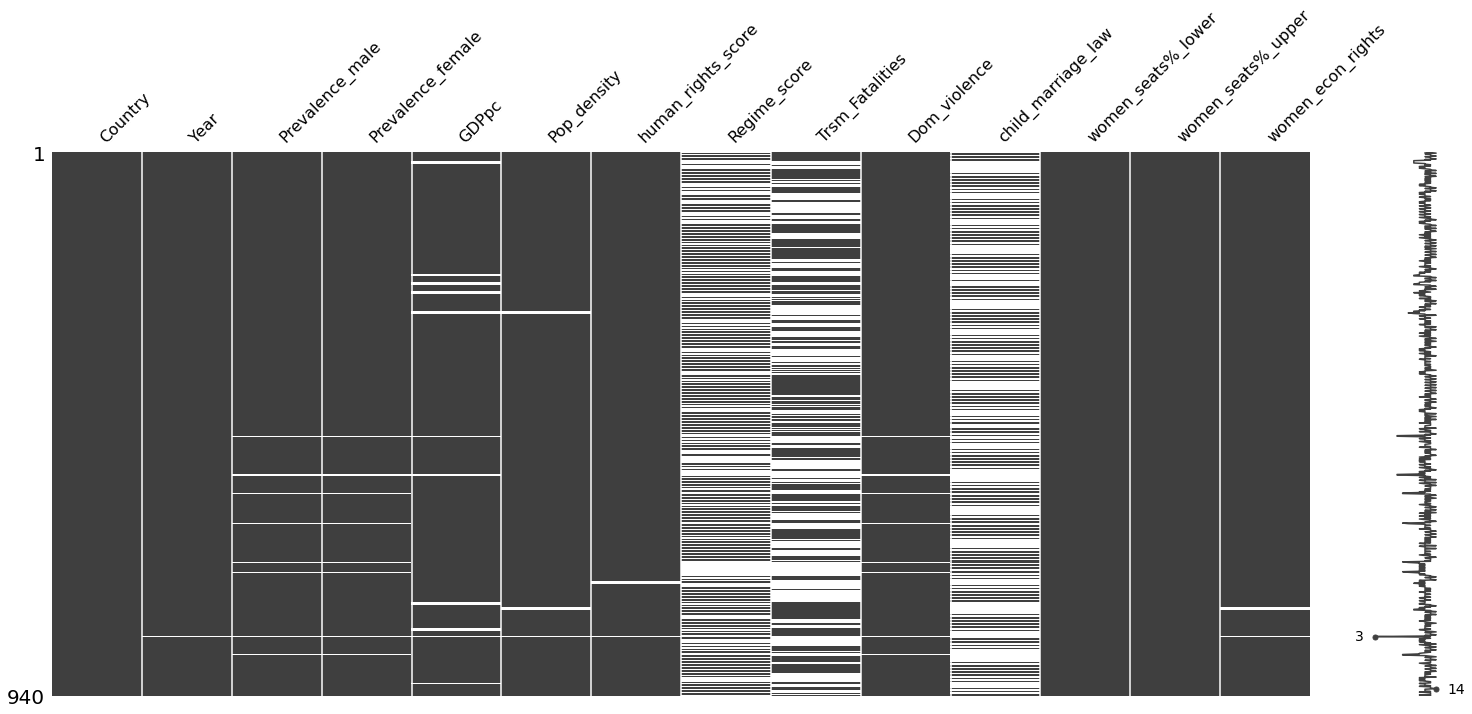

In [6]:
miss.matrix(dat)

#drop the rows where the predicted outcome is 0 (prevalence)
bool_series = pd.isnull(dat["Prevalence_female"]) #this is our outcome
#drop NA in outcome
dat = dat[~bool_series]
dat


### Methods Used 

#### 1 - Data Manipulation

Most data are downloadble - some datasets planned to be used in the proposal contain too many missing data 

For instances: HR (psychiatrists, nurses, social workers) in mental health sectors, average age of women who got married, percentage of women in senior management, etc. 

One important dataset was scraped: Women in Politics 


In [5]:
parliaments

,Rank,Country,Election_lower,seats_lower,women_seats_lower,women_seats%_lower,Election_upper,seats_upper,women_seats_upper,women_seats%_upper
3,1,Rwanda,03.09.2018,80,49,61.3%,26.09.2011,26,10,38.5%
4,2,Cuba,11.03.2018,605,322,53.2%,---,---,---,---
5,3,Bolivia,12.10.2014,130,69,53.1%,12.10.2014,36,17,47.2%
6,4,Mexico,01.07.2018,500,241,48.2%,01.07.2018,128,63,49.2%
7,5,Sweden,09.09.2018,349,165,47.3%,---,---,---,---
...,...,...,...,...,...,...,...,...,...,...
191,188,Oman,25.10.2015,85,1,1.2%,07.11.2015,85,14,16.5%
192,189,Yemen,27.04.2003,301,1,0.3%,28.04.2001,111,3,2.7%
193,190,"Micronesia, Fed. Sts.",07.03.2017,14,0,0.0%,---,---,---,---
194,"""",Papua New Guinea,24.06.2017,106,0,0.0%,---,---,---,---


### Methods Used 

#### 1 - Data Manipulation

Unit of Analysis: Country - Year (UN member states & from 2013 to 2017) 

Very first step: removed all missing data in the 'prevalence in women' because it is the outcome 

Clean the data 

Correlation Matrix

<AxesSubplot:>

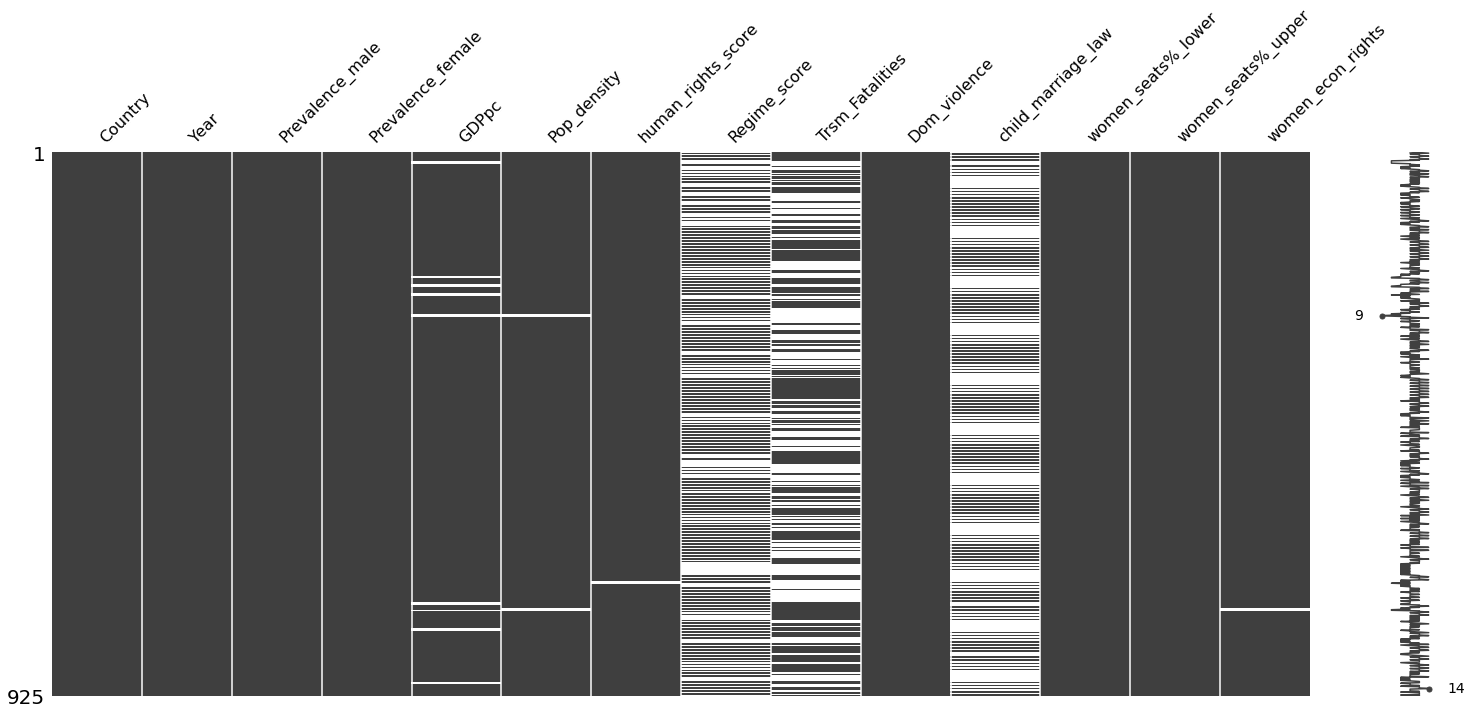

In [7]:
miss.matrix(dat)

## Most missing data in Regime type score and child marriage law are due to the time when meausurement was taken
## Most of the countries report regime score in some of the years so I filled NA with the average value
## Most of the countries report whether they have a law prohibiting child marriage 
##      so I filled NA with the the maximum (either 0 or 1)
## For missingness in terrorism fatalities I filled with 0 
## For the rest, I dropped the missing data  

In [8]:
dat['FminusM'] = dat.Prevalence_female - dat.Prevalence_male #difference between genders
dat.FminusM.describe()   #seems like female prevalance rate > male prevalence

count    925.000000
mean       0.691524
std        1.031037
min       -1.820614
25%        0.040652
50%        0.400313
75%        1.002751
max        4.171695
Name: FminusM, dtype: float64

In [9]:
#deal with NA Data 
dat['Regime_score'] = dat['Regime_score'].fillna(dat.groupby('Country')['Regime_score'].transform('mean'))
dat['Trsm_Fatalities'] = dat['Trsm_Fatalities'].fillna(0)
dat['child_marriage_law'] = dat['child_marriage_law'].fillna(dat.groupby('Country')['child_marriage_law'].transform('max'))
dat['child_marriage_law'] = dat['child_marriage_law'].fillna(0)

dat['women_seats%_lower'] = dat['women_seats%_lower'].str.strip('%').astype('float')
dat['women_seats%_lower'] = dat['women_seats%_lower'].div(100)
dat['women_seats%_lower']

dat.drop('women_seats%_upper', axis = 1, inplace = True)

dat.dropna(inplace = True)

In [10]:
#correlation Matrix
corr_mat = dat.corr().loc[['FminusM','Prevalence_female','Prevalence_male'],
                ['GDPpc','Pop_density', 'human_rights_score', 'Regime_score', 'Trsm_Fatalities',
                'Dom_violence', 'child_marriage_law', 'women_seats%_lower','women_econ_rights']]

corr_mat.T

,FminusM,Prevalence_female,Prevalence_male
GDPpc,0.431605,0.455937,0.359961
Pop_density,0.043380,0.009747,-0.016468
human_rights_score,0.325370,0.276122,0.172729
Regime_score,0.239572,0.157330,0.060085
Trsm_Fatalities,0.054795,0.100138,0.107357
Dom_violence,-0.289333,-0.108391,0.046534
child_marriage_law,0.055614,-0.132063,-0.232059
women_seats%_lower,0.256141,0.197588,0.107109
women_econ_rights,0.384629,0.311383,0.182258


### 2 - Data Visualization

Scatterplot to demonstrate the prevalence difference in genders

Barcharts to demonstrate the distribution of variables 

Heatmap to determine correlations


### 3 - Statistical Learning 

Linear model

K nearest neighbors 

Decision tree

Bagging decision tree

Random forest 

More models are used to compare results and look for the most predictive model 

### Preliminary results

Are mental health disorders more prevalent among women? 


In [13]:
dat.FminusM.describe() 


count    761.000000
mean       0.733592
std        1.094175
min       -1.820614
25%        0.009645
50%        0.481569
75%        1.109263
max        4.171695
Name: FminusM, dtype: float64

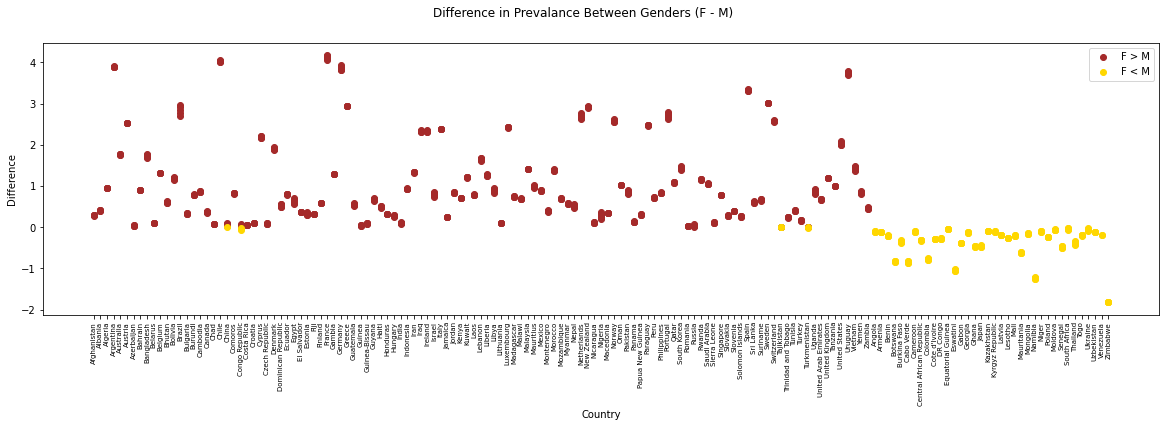

In [16]:
#To visualiza it 
fig = plt.figure(figsize = (20,5))
fig.suptitle("Difference in Prevalance Between Genders (F - M)")
#clrs = ['green' if (x <= 0) else 'red' for x in dat.FminusM ]
plt.scatter('Country','FminusM', data = dat.query("FminusM >= 0"), color = 'brown', label = 'F > M')
plt.scatter('Country','FminusM', data = dat.query("FminusM < 0"), color = 'gold', label = 'F < M')
plt.xlabel("Country")
plt.ylabel("Difference")
plt.xticks(rotation='vertical', size = 7)
plt.legend()
plt.show()

As mentioned earlier, the prevalence of mental health disorders has not changed significantly over the past years; therefore the difference between genders has also not changed much over time. 
Countries where the prevalence in men is greater than women remain that pattern over years as well. 

It is reasonable to believe in general mental health disorders are more prevalent in women than men.

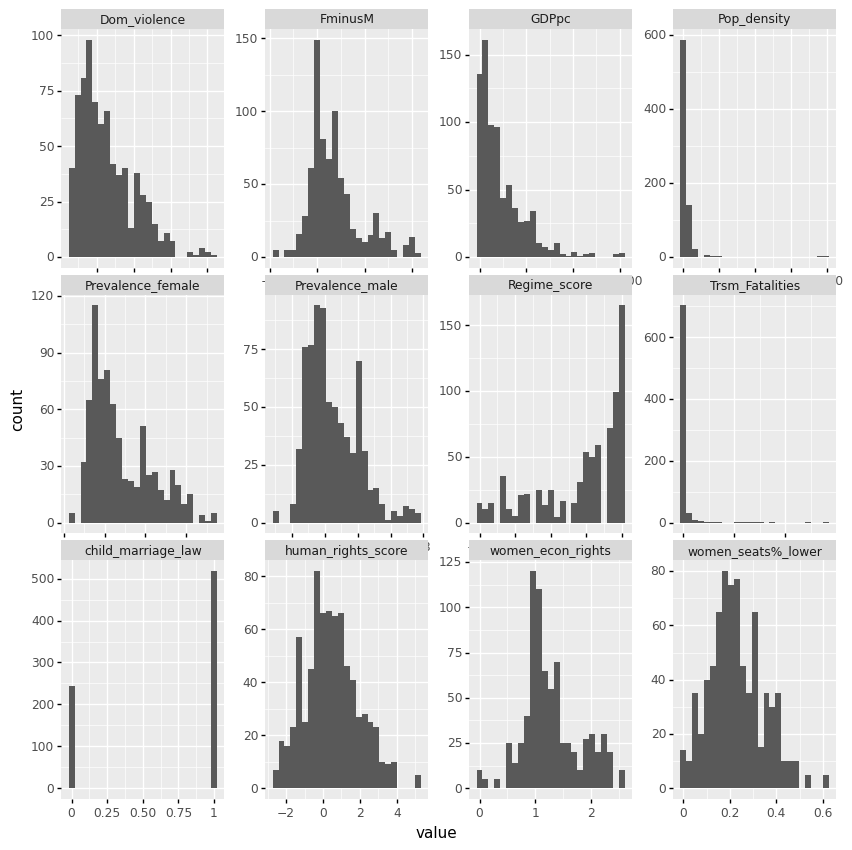

<ggplot: (-9223371906786605736)>

In [17]:
d =dat.select_dtypes(include="float64").melt()
d = d[d['variable'] != 'Year']

(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins = 25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,10),
          subplots_adjust={'wspace':0.25})
)

Text(0.5, 1.0, 'Correlation')

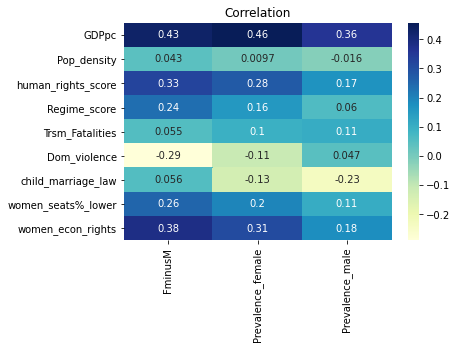

In [18]:
ax = plt.axes()
sns.heatmap(corr_mat.T, annot = True, cmap = 'YlGnBu')
ax.set_title('Correlation')

The correlation matrix shows some very counterintuitive results:

Negative correlation between the rate of domestic violence in women and the prevalence of mental health disorders in women

Higher women's economic rights link with higher rate of prevalence

GDP per capita is a surprisingly driving factor

In [48]:
#split data
y = dat[['Prevalence_female']]
x = dat.drop(columns =['FminusM','Prevalence_male','Prevalence_female'])

train_x, test_x, train_y, test_y = train_test_split(x,y,test_size = .25,random_state=321)


train_x = train_x[['GDPpc', 'Pop_density', 'human_rights_score',
       'Regime_score', 'Trsm_Fatalities', 'Dom_violence', 'child_marriage_law',
       'women_seats%_lower', 'women_econ_rights']]
test_x = test_x[['GDPpc', 'Pop_density', 'human_rights_score',
       'Regime_score', 'Trsm_Fatalities', 'Dom_violence', 'child_marriage_law',
       'women_seats%_lower', 'women_econ_rights']]


In [49]:
fold_generator = KFold(n_splits=5, shuffle=True,random_state=321)

preprocess = ColumnTransformer(transformers=[('num',
            pp.MinMaxScaler(), ['GDPpc', 'Pop_density', 'human_rights_score',
                   'Regime_score', 'Trsm_Fatalities', 'Dom_violence', 'child_marriage_law',
                   'women_seats%_lower', 'women_econ_rights'])])

#create our model pipe
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


#Specify the models
search_space = [
    # Linear Model
    {'model' : [LM()]},

    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},

    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},

    # The Bagging decision tree model
    {'model': [Bag()]},

    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]


search = GridSearchCV(pipe, search_space,
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

search.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=321, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['GDPpc',
                                                                          'Pop_density',
                                                                          'human_rights_score',
                                                                          'Regime_score',
                                                                          'Trsm_Fatalities',
                                                                          'Dom_violence',
                                                                          'child_marriage_law',
                                                                        

In [50]:
print("Best score: ", search.best_score_, '\nBest model: ', search.best_params_)

Best score:  -0.7179365184317132 
Best model:  {'model': BaggingRegressor()}


In [51]:
pred_y = search.predict(test_x)

In [55]:
m.mean_squared_error(test_y,pred_y)

0.2581228880844687

In [57]:
m.r2_score(test_y,pred_y)

0.9392771713243763

### Lessons 

1. Data related to mental health or even health, and gender ineuqality gap are poorly reported and measured. 
2. Counterintuitive data might indicate the lack of awareness in mental health 
3. Some measures are outdated and some are relatively new, so the country-year analysis does not provide as many insights as expected. 
4. For this project, I would look at into variables indictating people's behaviors: access to drugs, alchohol consumption, average family size, average years of schooling, etc. 